<img src="logos.jpg" width="700" />

# Tensorflow example using Mnist dataset

The purpose of this notebook is to ilustrate the use of __Tensorflow__ package in an example that includes the construction of a neural network and the use of a supervised learning approach based in the back-propagation theory. The proposed example is based on the classic Mnist dataset in which the main objective is to identify images of hand-written digits.

Example main features:

1. All the code was implemented in Python 3.5 https://www.python.org/ 
2. The  Python packages required to run the programs are the following:
    * Jupyter notebook (Python interactive prompt) http://jupyter.org/index.html
    * Tensorflow (Representation-classification) https://www.tensorflow.org/
    * Numpy (classification) http://www.numpy.org/
    * Matplotlib (visualization) https://matplotlib.org/
3. The tensorflow version used correspond to a standalone application which means that does not support the use of parallel 
   computations on GPUs.

    
## Step 1: Load the MNIST dataset

The Mnist dataset includes over 60,000 training images, plus 10,000 test images resized into 28x28 matices with grayscale values between 0 and 254.The following shows how to load this dataset:

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


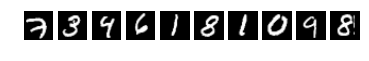

Labels: 7 , 3 , 4 , 6 , 1 , 8 , 1 , 0 , 9 , 8


In [49]:
#Command used to see the plot inside the Jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#Package used to get the Mnist dataset from tensorflow available examples
from tensorflow.examples.tutorials.mnist import input_data
#Load the Mnist dataset
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
labels=[]
#Plot the first ten images of the Mnist dataset
for number in range(10):
    #Add a subplot to the matplotlib main canvas
    plt.subplot(1,10,number+1)
    #Get images and labels from the dataset
    image=mnist.train.images[number]
    label=mnist.train.labels[number]
    #Transform the image to a numpy object to manipulate it
    image=np.array(image, dtype='float')
    #Reshape(rows,columns) the digits from a matrix of (784,) to a matrix of (28,28)
    plt.imshow(image.reshape(28, 28), cmap='Greys_r')
    #Eliminate axis labels from the plot
    plt.axis('off')
    labels.append(label)
#Show the plot (ten images)    
plt.show()
#Transform the labels to a single number instead of a list
labels=[str([i for i,y in enumerate(x) if y == 1][0]) for x in labels]
print ("Labels: "+" , ".join(labels))

## Step 2: Preprocess the Mnist dataset
1. Reshape the digits from each training image to a matrix of (28,28) (rows,columns)

In [72]:
#Empty lists for storing reshaped images and labels
trainingImages= []
trainingLabels=[]
#For each image
for image in mnist.train.images:
    #Transform all the values to a float data type
    image=np.array(image, dtype='float')
    #Transform an image to a matrix of 28x28
    trainingImages.append(image.reshape(28, 28))
#Similr to the images, reshape each label to a float data type    
for label in mnist.train.labels:   
    trainingLabels.append(str([i for i,y in enumerate(label) if y == 1][0]))
#Transform the training list to a numpy array (for compatibility with tensorflow function)   
trainingImages = np.array(trainingImages, np.float32)    
trainingLabels = np.array(trainingLabels, np.float32) 
print ("Reshaped image examples")
print(trainingImages[:2])
print ("Reshaped label examples")
print(trainingLabels[:2])
print ("Images dimensions: " + str(trainingImages.shape))
print ("Labels dimensions: " + str(trainingImages.shape))



Reshaped image examples
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Reshaped label examples
[7. 3.]
Images dimensions: (55000, 28, 28)
Labels dimensions: (55000, 28, 28)


2\. Reshape the digits from each test image to a matrix of (28,28) (rows,columns)

In [73]:
testImages= []
testLabels=[]
for image in mnist.test.images:
    image=np.array(image, dtype='float')
    testImages.append(image.reshape(28, 28))   
for label in mnist.test.labels:   
    testLabels.append(str([i for i,y in enumerate(label) if y == 1][0]))  
testImages = np.array(testImages, np.float32)    
testLabels = np.array(testLabels, np.float32) 

## Step 3: Define tensorflow graph 

1. Back-propagtion intuition

<img src="backPropagation.jpg" alt="Drawing" style="width: 600px;"/>


2\.  multi-layer perceptron proposed for this example

<img src="backPropagation2.png" alt="Drawing" style="width: 600px;"/>


3\.  Create the proposed graph in the tensorflow environment considering that nodes in the graph represent mathematical operations, whereas edges represent data (tensors) that is communicated from one node to others. It is important to highlight that tensors are multidimensional arrays (representing vectors with a 1D tensors, matrices with a 2D tensors, etc.).

In [76]:
import tensorflow as tf

#Number of neurons for the input layer
n_inputs = 28*28 #Features size
#Number of neurons per hidden layer
n_hidden1 = 300
n_hidden2 = 300
n_hidden3 = 100
#Number of neurons for the output layer
n_outputs = 10

Inside the graph construction, a placeholder is simply a variable that we will assign data to at a later date. It allows us to create our operations and build our computation graph, without needing the data.

In [77]:
#https://www.tensorflow.org/api_docs/python/tf/placeholder
#Training sample representation
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")  #2D tensor
#Target sample representation
y = tf.placeholder(tf.int32, shape=(None), name="y") #1D tensor

After define the placeholders, we can create a function that represents the behavior of a neural network layer. It is important to noticed that in the function there are define multiple tensorflow variables which helps to represent shared, persistent values across a graph execution. 

In [78]:
"""
Function parameters:

X = Vector features (28x28)
n_neurons = Number of neurons for a layer
name= Layer name
activation = Activation functions used for each neuron
"""
def neuron_layer(X, n_neurons, name, activation=None):
    #Tensorflow name scope to group together operations (nodes) in the graph
    with tf.name_scope(name):
        #Get the number of elements by checking the vectors feature shape
        n_inputs = int(X.get_shape()[1])
        #Create a random weight matrix using a Gaussian distribution
        #The standard deviation helps the algorithm to converge faster in a training phase
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        #Create a tensorflow variable for the bias
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        """
        ATTENTION: Creation of the graph in tensorflow
        Compute the weighted sum of the inputs plus the bias term for each neuron the layer
        https://www.tensorflow.org/api_docs/python/tf/matmul
        """
        Z = tf.matmul(X, W) + b
        #Returns the activation function of each neuron in the layer
        if activation is not None:
            return activation(Z)
        else:
            return Z

Finally, the different layers are created in the graph (neural network) using the previously created function.

In [80]:
#Tensorflow name scope to group together operations (nodes) in the graph
with tf.name_scope("dnn"):
    # The first layer take the feature vector as input
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",activation=tf.nn.relu)
    #The second layer take the output of the first layer as input
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",activation=tf.nn.relu)
    #The third layer take the output of the second layer as input
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",activation=tf.nn.relu)
    #The output of the third layer is taken as input for the final layer
    ouput = neuron_layer(hidden3, n_outputs, name="outputs")

The activation function use in the neural network is presented below:

<img src="ReLU.png" alt="Drawing" style="width: 500px;"/>